In [1]:
import glob
import pandas as pd
import json
import pickle as pkl

import numpy as np
import matplotlib.pyplot as plt
import hist
import mplhep
import matplotlib as mpl
from matplotlib.lines import Line2D

mpl.rcParams["font.size"] = 16
mpl.rcParams["lines.linewidth"] = 2
mpl.rcParams["grid.color"] = "#CCCCCC"
mpl.rcParams["grid.linewidth"] = 0.5
mpl.rcParams["figure.edgecolor"] = "none"

import matplotlib.ticker as mticker
formatter = mticker.ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-3, 3))
mplhep.style.use(["CMS", "firamath"])

In [3]:
def get_sum_sumgenweight(pkl_files, year, sample):
    sum_sumgenweight = 0
    for ifile in pkl_files:
        # load and sum the sumgenweight of each
        with open(ifile, "rb") as f:
            metadata = pkl.load(f)
        sum_sumgenweight = sum_sumgenweight + metadata[sample][year]["sumgenweight"]
    return sum_sumgenweight

def get_xsecweight(pkl_files, year, sample, is_data, luminosity):
    if not is_data:
        # find xsection
        f = open("../fileset/xsec_pfnano.json")
        xsec = json.load(f)
        f.close()
        try:
            xsec = eval(str((xsec[sample])))
        except ValueError:
            print(f"sample {sample} doesn't have xsecs defined in xsec_pfnano.json so will skip it")
            return None

        # get overall weighting of events.. each event has a genweight...
        # sumgenweight sums over events in a chunk... sum_sumgenweight sums over chunks
        xsec_weight = (xsec * luminosity) / get_sum_sumgenweight(pkl_files, year, sample)
    else:
        xsec_weight = 1
    return xsec_weight

In [99]:
lepmiso_axis = hist.axis.Regular(
    20, 0, 0.5, name="lepmiso", label=r"Lepton mini-iso"
)
lepdR_axis = hist.axis.Regular(
    50, 0, 3, name="lepdr", label=r"$\Delta R$(lepton, jet)"
)
leppt_axis = hist.axis.Regular(
    40, 30, 400, name="leppt", label=r"Lepton $p_T$ [GeV]"
)
lepeta_axis = hist.axis.Regular(
    40, 0, 2.5, name="lepeta", label=r"Lepton $|\eta|$"
)
hm_axis = hist.axis.Regular(
    40, 0, 300, name="hm", label=r"Higgs reco mass [GeV]"
)
metdphi_axis = hist.axis.Regular(
    40, -3.2, 3.2, name="metdphi", label=r"$\Delta \phi (MET, j)$"
)
metpt_axis = hist.axis.Regular(
    40, 20, 400, name="metpt", label=r"MET [GeV]"
)
channel_axis = hist.axis.StrCategory([], name="channel", growth=True)
sample_axis = hist.axis.StrCategory([], name="name", growth=True)

h_lepmiso_lowpt = hist.Hist(lepmiso_axis, channel_axis, sample_axis)
h_lepmiso_highpt = hist.Hist(lepmiso_axis, channel_axis, sample_axis)
h_lepeta = hist.Hist(lepeta_axis, channel_axis, sample_axis)
h_lepdr = hist.Hist(lepdR_axis, leppt_axis, channel_axis, sample_axis)
# h_metdphi = hist.Hist(metdphi_axis, metpt_axis, channel_axis, sample_axis)
#h_metdphi = hist.Hist(metdphi_axis, leppt_axis, channel_axis, sample_axis)
h_metdphi = hist.Hist(metdphi_axis, hm_axis, channel_axis, sample_axis)
h_hm = hist.Hist(hm_axis, channel_axis, sample_axis)

# odir = "/eos/uscms/store/user/cmantill/boostedhiggs/Jan16_sel_exceptiso_2018/"
odir = "/eos/uscms/store/user/cmantill/boostedhiggs/Jan16_sel_exceptdR_2018/"

samples_dict = {
    "ggH": ["GluGluHToWW_Pt-200ToInf_M-125"],
    "VBF": ["VBFHToWWToAny_M-125_TuneCP5_withDipoleRecoil"],
    "QCD": [
        "QCD_Pt_170to300",
        "QCD_Pt_300to470",
        "QCD_Pt_470to600",
        "QCD_Pt_600to800",
        "QCD_Pt_800to1000",
        "QCD_Pt_1000to1400",
        "QCD_Pt_1400to1800",
        "QCD_Pt_1800to2400",
        "QCD_Pt_2400to3200",
        "QCD_Pt_3200toInf",
    ],
    "TT": [
        "TTTo2L2Nu",
        "TTToHadronic",
        "TTToSemiLeptonic",
    ],
    "WJets": [
        #"WJetsToLNu_HT-100To200",
        "WJetsToLNu_HT-200To400",
        "WJetsToLNu_HT-400To600",
        "WJetsToLNu_HT-600To800",
        "WJetsToLNu_HT-800To1200",
        "WJetsToLNu_HT-1200To2500",
        "WJetsToLNu_HT-2500ToInf",
    ],
}
year = "2018"

pt_threshold = {
    "mu": 55,
    "ele": 120,
}

for ch in ["ele", "mu"]:
    for key,samples in samples_dict.items():
        for sample in samples:
            parquet_files = glob.glob(f"{odir}/{sample}/outfiles/*_{ch}.parquet")
            pkl_files = glob.glob(f"{odir}/{sample}/outfiles/*.pkl")

            data = pd.read_parquet(parquet_files, columns=["lep_misolation", 
                                                           "lep_isolation", 
                                                           "lep_pt", 
                                                           f"weight_{ch}", 
                                                           "lep_eta",
                                                           "lep_fj_dr",
                                                           "met_fj_dphi",
                                                           "rec_higgs_m",
                                                           "met_pt",
                                                           ])

            luminosity = 137640.0

            event_weight = get_xsecweight(pkl_files, year, sample, False, luminosity)
            event_weight *= data[f"weight_{ch}"]

            low_pt_sel = (data["lep_pt"] < pt_threshold[ch]) & (data["lep_isolation"] < 0.15)
            high_pt_sel = (data["lep_pt"] > pt_threshold[ch])

            miso = data["lep_misolation"].values
            eta = data["lep_eta"].values
            met_fj_dphi = data["met_fj_dphi"].values
            dr = data["lep_fj_dr"].values
            pt = data["lep_pt"].values
            met_pt = data["met_pt"].values
            rec_higgs_m = data["rec_higgs_m"].values
        
            h_lepmiso_lowpt.fill(miso[low_pt_sel], ch, key, weight=event_weight[low_pt_sel])
            h_lepmiso_highpt.fill(miso[high_pt_sel], ch, key, weight=event_weight[high_pt_sel])

            if ch == "mu":
                miso_sel = (data["lep_misolation"] < 0.2)
                pre_sel = low_pt_sel | (high_pt_sel & miso_sel)
            else:
                pre_sel = low_pt_sel | high_pt_sel

            dr_sel = (dr > 0.03) & (dr < 0.8)
            #if ch == "ele":
            #    dr_sel = dr_sel & (np.abs(eta) < 1.57)
            # h_metdphi.fill(metdphi=met_fj_dphi[pre_sel & dr_sel], metpt=met_pt[pre_sel & dr_sel], channel=ch, name=key, weight=event_weight[pre_sel & dr_sel])
            # h_metdphi.fill(metdphi=met_fj_dphi[pre_sel & dr_sel], leppt=pt[pre_sel & dr_sel], channel=ch, name=key, weight=event_weight[pre_sel & dr_sel])
            h_metdphi.fill(metdphi=met_fj_dphi[pre_sel & dr_sel], hm=rec_higgs_m[pre_sel & dr_sel], channel=ch, name=key, weight=event_weight[pre_sel & dr_sel])

            pre_sel = pre_sel & (np.abs(met_fj_dphi) < 1.57)

            h_lepeta.fill(abs(eta[pre_sel]), ch, key, weight=event_weight[pre_sel])
            h_lepdr.fill(lepdr=dr[pre_sel], leppt=pt[pre_sel], channel=ch, name=key, weight=event_weight[pre_sel])

            h_hm.fill(hm=rec_higgs_m[pre_sel & dr_sel], channel=ch, name=key, weight=event_weight[pre_sel & dr_sel])

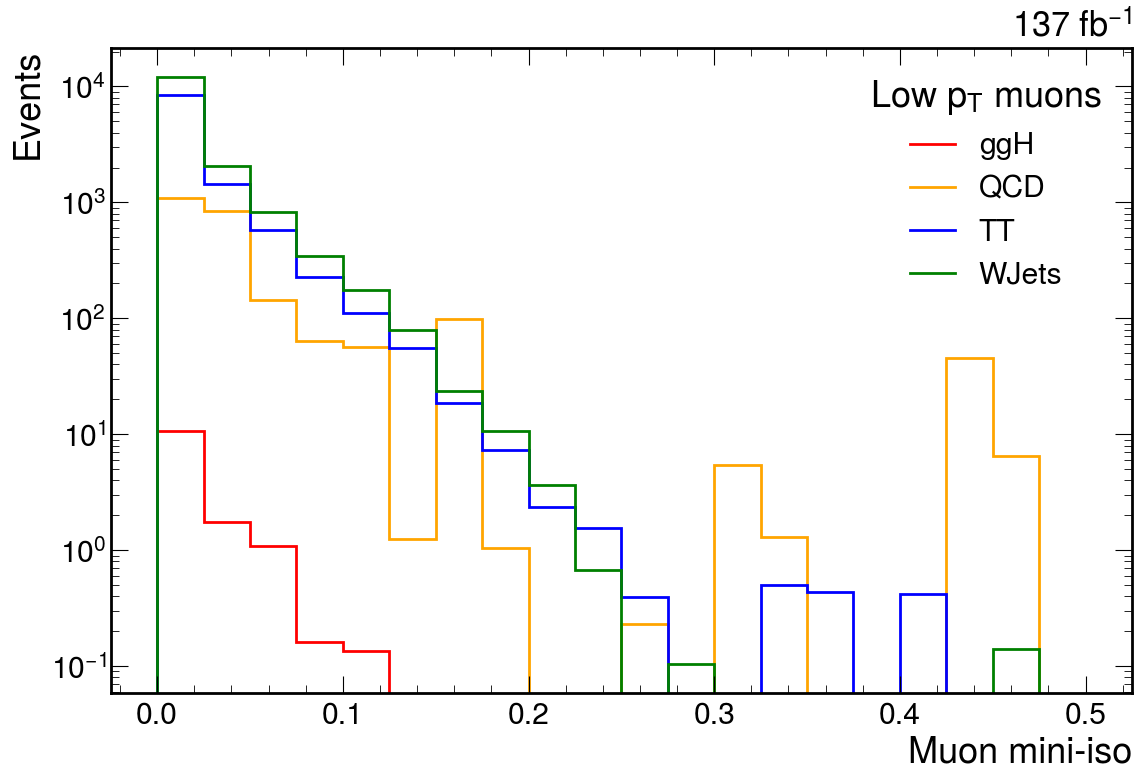

In [29]:
fig, ax = plt.subplots(figsize=(12, 8))
legend_elements = []
color_by_sample = {
    "ggH": "red",
    #"VBF": "pink",
    "QCD": "orange",
    "TT": "blue",
    "WJets": "green",
}
for key in color_by_sample.keys():
    mplhep.histplot(
        h_lepmiso_lowpt[{"name": key, "channel": "mu"}],
        lw=2,
        #density=True,
        color=color_by_sample[key],
        flow="none"
    )
    legend_elements.append(
        Line2D([0], [0], color=color_by_sample[key], lw=2, label=key)
    )
ax.set_yscale("log")
ax.legend(handles=legend_elements, title=r"Low $p_T$ muons")
ax.set_ylabel("Events")
ax.set_xlabel("Muon mini-iso")
plt.tight_layout()
mplhep.cms.lumitext(r"137 fb$^{-1}$")
fig.savefig("lepminiiso_lowpt.png")

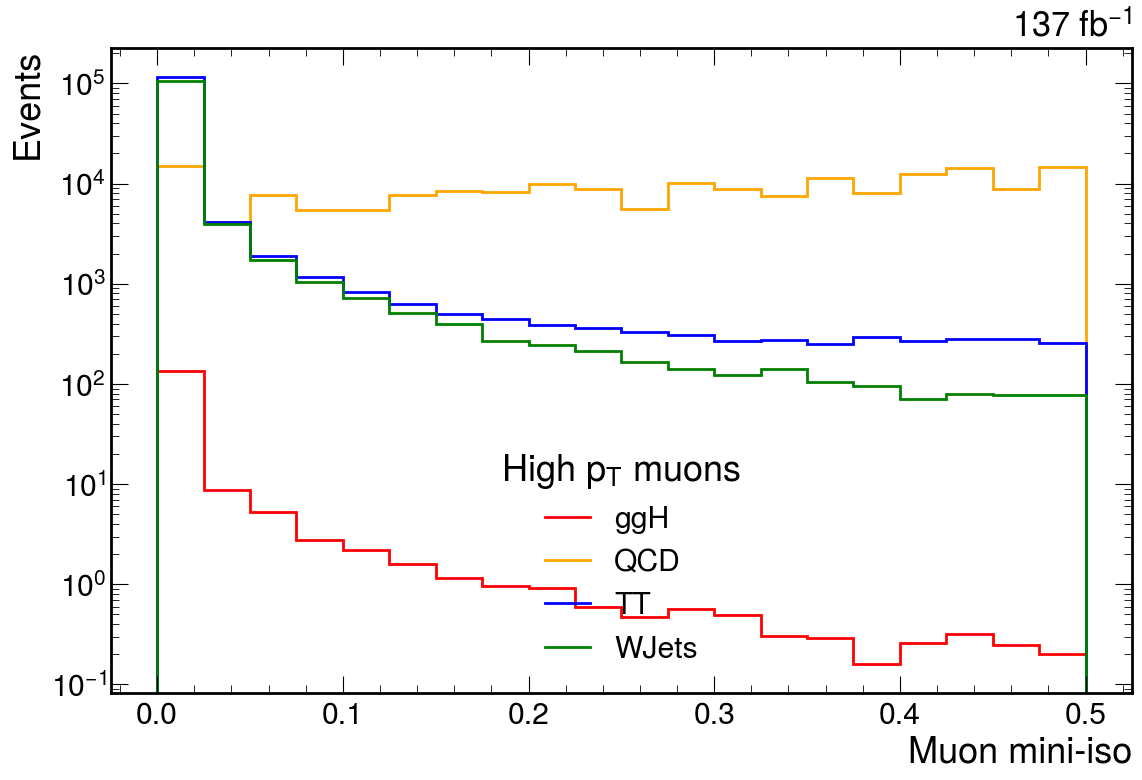

In [18]:
fig, ax = plt.subplots(figsize=(12, 8))
legend_elements = []
for key in color_by_sample.keys():
    mplhep.histplot(
        h_lepmiso_highpt[{"name": key, "channel": "mu"}],
        lw=2,
        #density=True,
        color=color_by_sample[key],
        flow="none"
    )
    legend_elements.append(
        Line2D([0], [0], color=color_by_sample[key], lw=2, label=key)
    )
ax.set_yscale("log")
ax.legend(handles=legend_elements, title=r"High $p_T$ muons")
ax.set_xlabel("Muon mini-iso")
ax.set_ylabel("Events")
plt.tight_layout()
mplhep.cms.lumitext(r"137 fb$^{-1}$")
fig.savefig("lepminiiso_highpt.png")

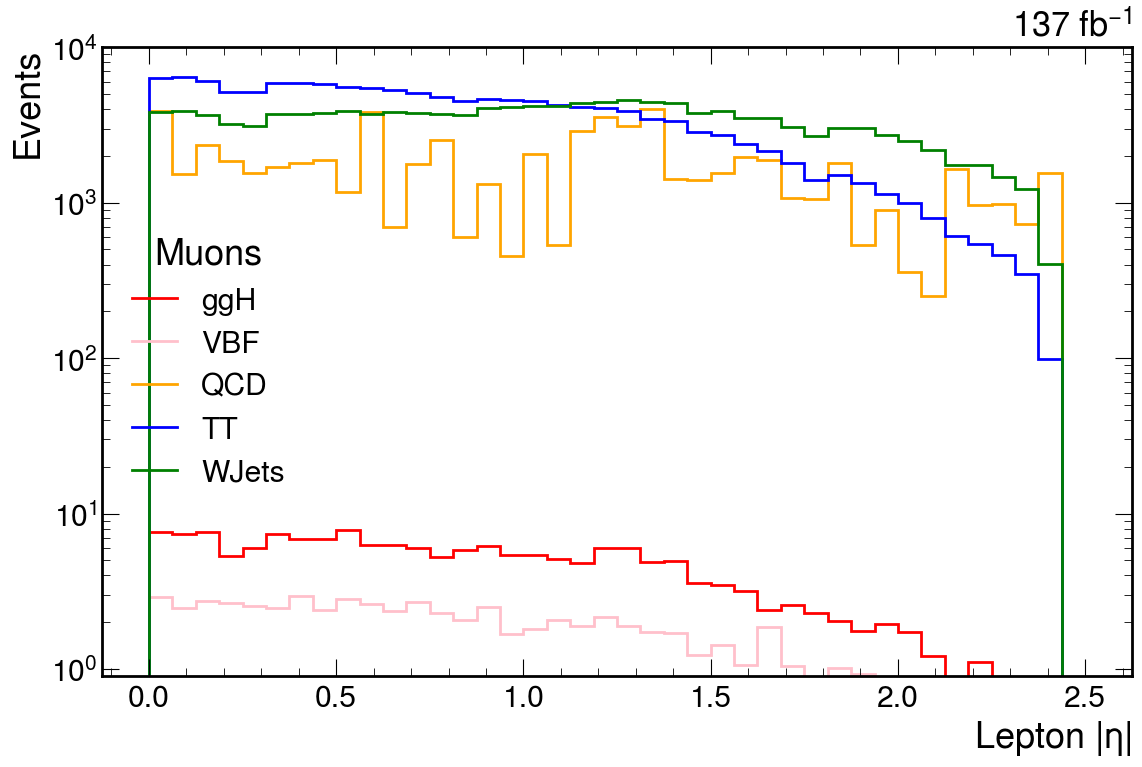

In [38]:
fig, ax = plt.subplots(figsize=(12, 8))
legend_elements = []
color_by_sample = {
    "ggH": "red",
    "VBF": "pink",
    "QCD": "orange",
    "TT": "blue",
    "WJets": "green",
}
for key in color_by_sample.keys():
    mplhep.histplot(
        h_lepeta[{"name": key, "channel": "mu"}],
        lw=2,
        #density=True,
        color=color_by_sample[key],
        flow="none"
    )
    legend_elements.append(
        Line2D([0], [0], color=color_by_sample[key], lw=2, label=key)
    )
ax.set_ylim(0.9, 10000)
ax.set_yscale("log")
ax.legend(handles=legend_elements, title=r"Muons")
ax.set_ylabel("Events")
plt.tight_layout()
mplhep.cms.lumitext(r"137 fb$^{-1}$")
fig.savefig("lepeta_mu.png")


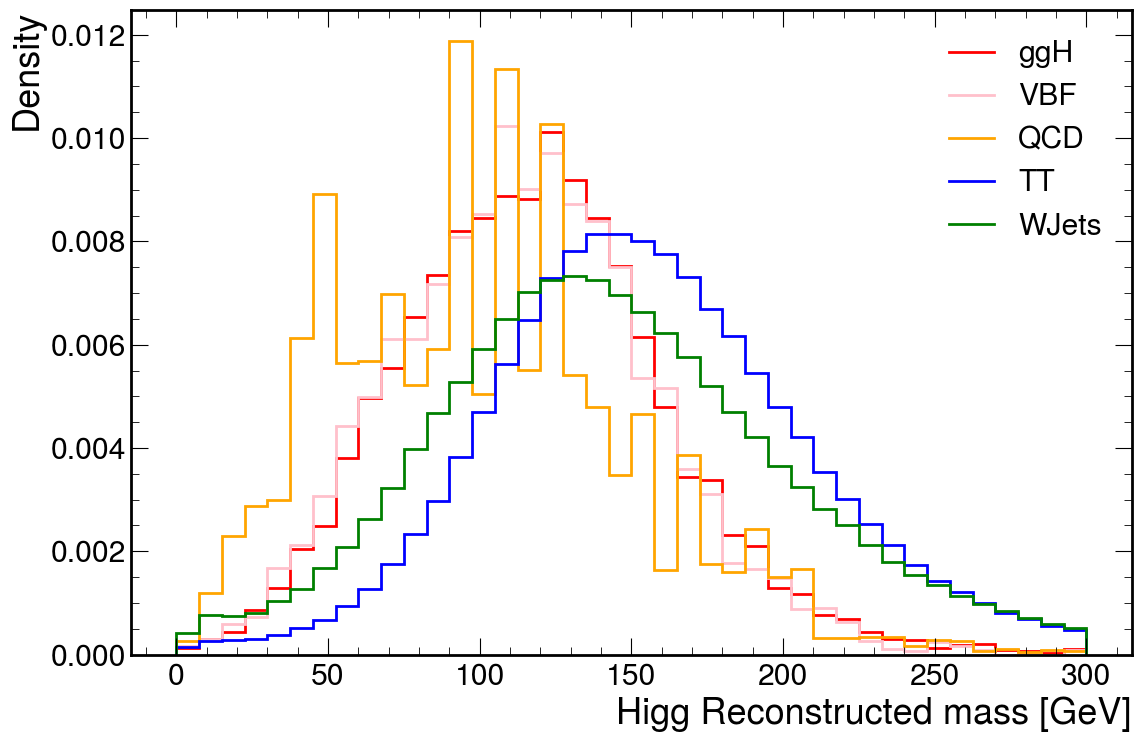

In [100]:
fig, ax = plt.subplots(figsize=(12, 8))
legend_elements = []
color_by_sample = {
    "ggH": "red",
    "VBF": "pink",
    "QCD": "orange",
    "TT": "blue",
    "WJets": "green",
}
for key in color_by_sample.keys():
    mplhep.histplot(
        h_hm[{"name": key, "channel": sum}],
        lw=2,
        density=True,
        color=color_by_sample[key],
        flow="none"
    )
    legend_elements.append(
        Line2D([0], [0], color=color_by_sample[key], lw=2, label=key)
    )
ax.legend(handles=legend_elements)
ax.set_ylabel("Density")
ax.set_xlabel("Higg Reconstructed mass [GeV]")
plt.tight_layout()
fig.savefig("hm.png")

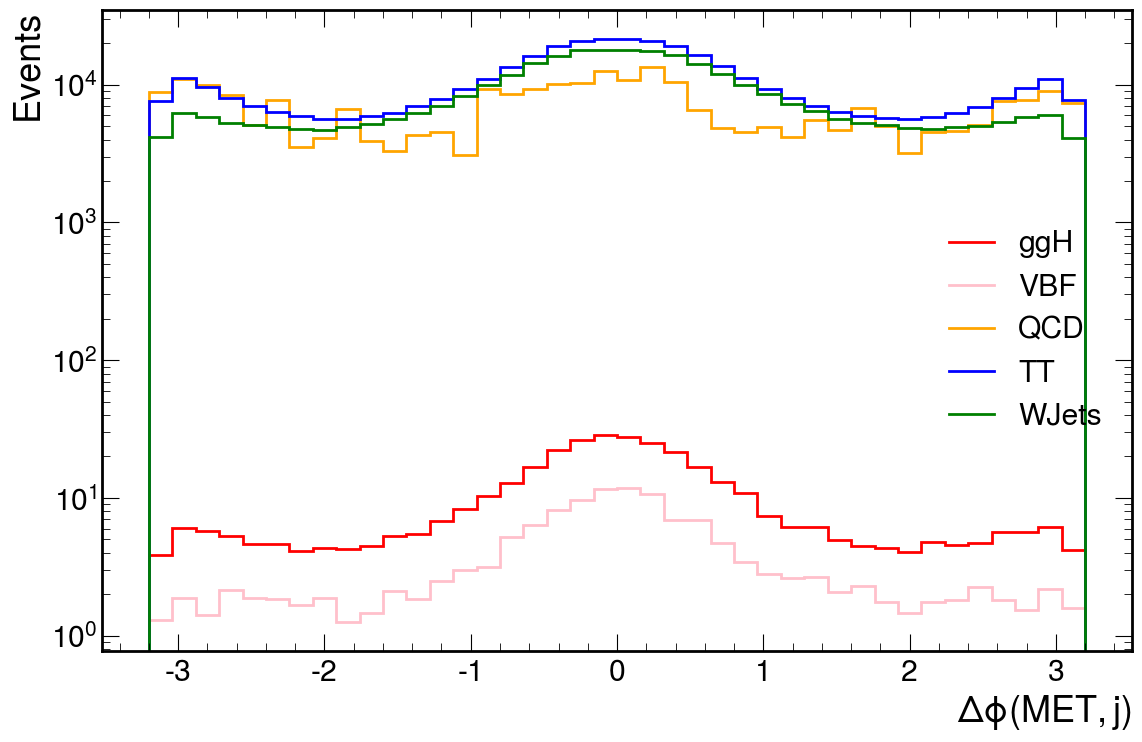

In [101]:
fig, ax = plt.subplots(figsize=(12, 8))
legend_elements = []
color_by_sample = {
    "ggH": "red",
    "VBF": "pink",
    "QCD": "orange",
    "TT": "blue",
    "WJets": "green",
}
for key in color_by_sample.keys():
    mplhep.histplot(
        h_metdphi[{"name": key, "channel": sum, "hm": sum}],
        lw=2,
        #density=True,
        color=color_by_sample[key],
        flow="none"
    )
    legend_elements.append(
        Line2D([0], [0], color=color_by_sample[key], lw=2, label=key)
    )
ax.set_yscale("log")
ax.legend(handles=legend_elements)
ax.set_ylabel("Events")
plt.tight_layout()
#mplhep.cms.lumitext(r"137 fb$^{-1}$")
fig.savefig("metdphi.png")

/tmp/ipykernel_2996/3550149983.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_2996/3550149983.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_2996/3550149983.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_2996/3550149983.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_2996/3550149983.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


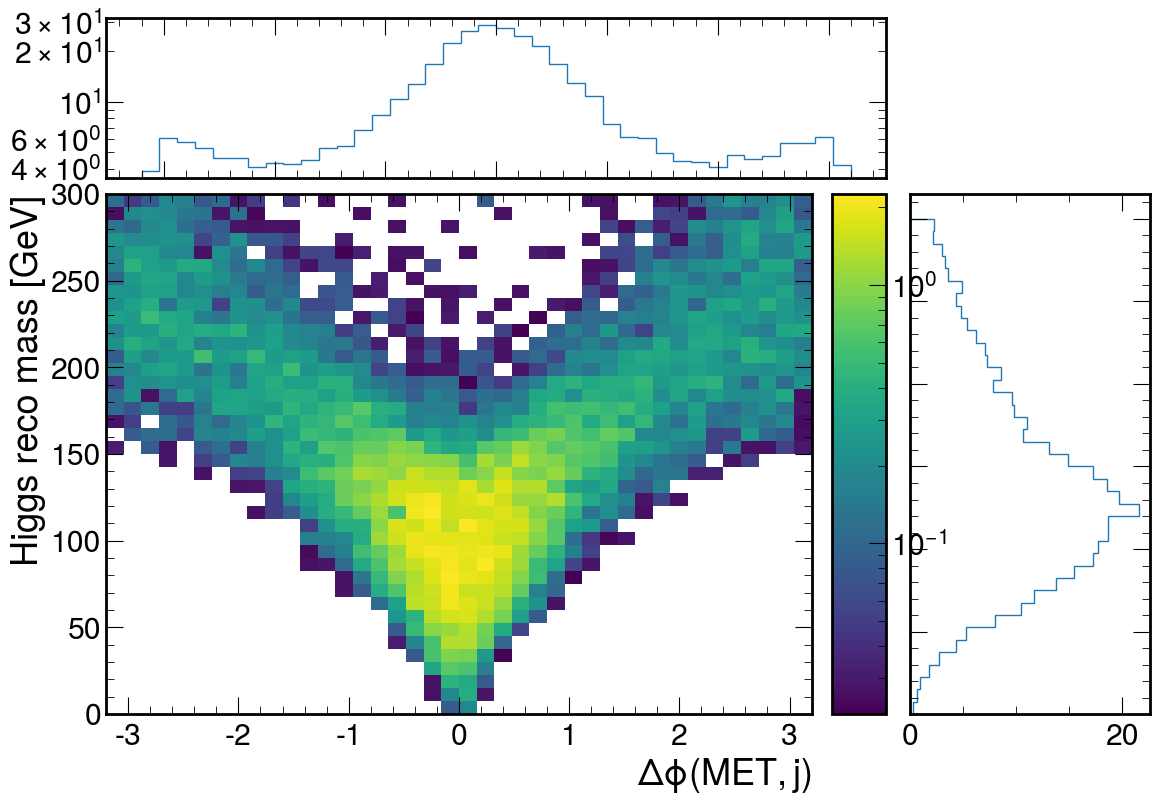

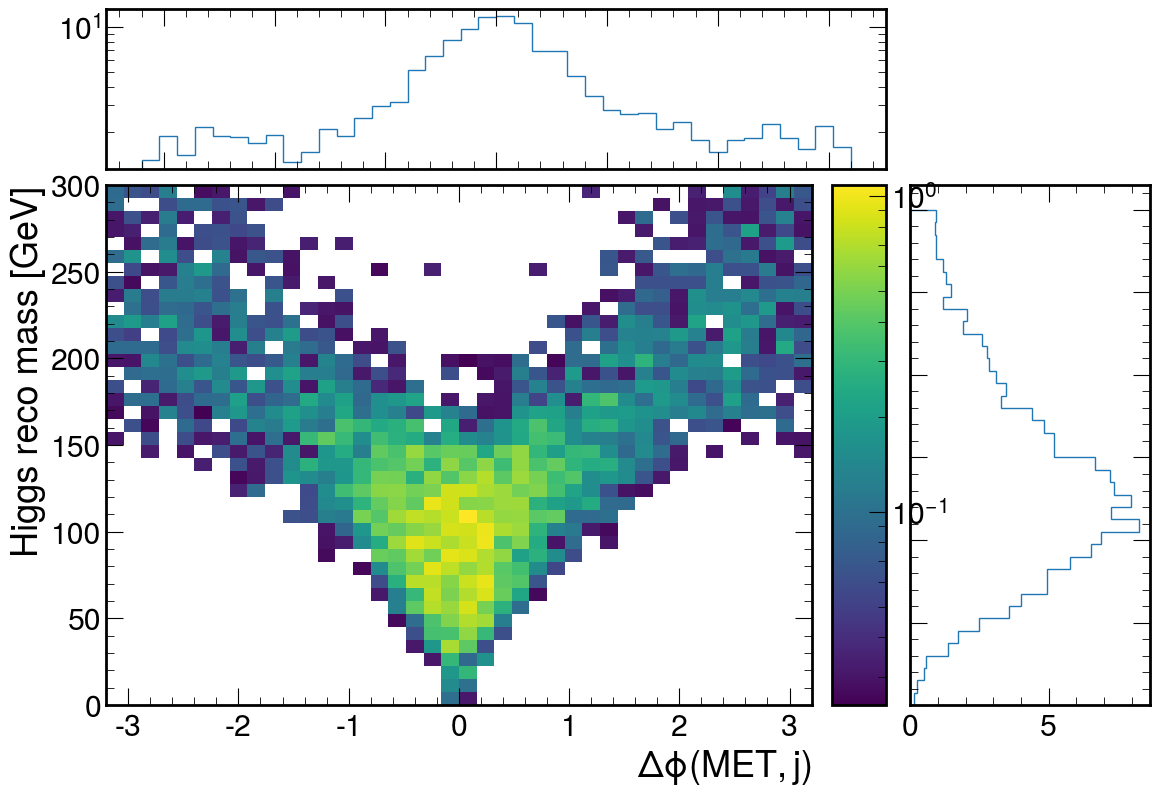

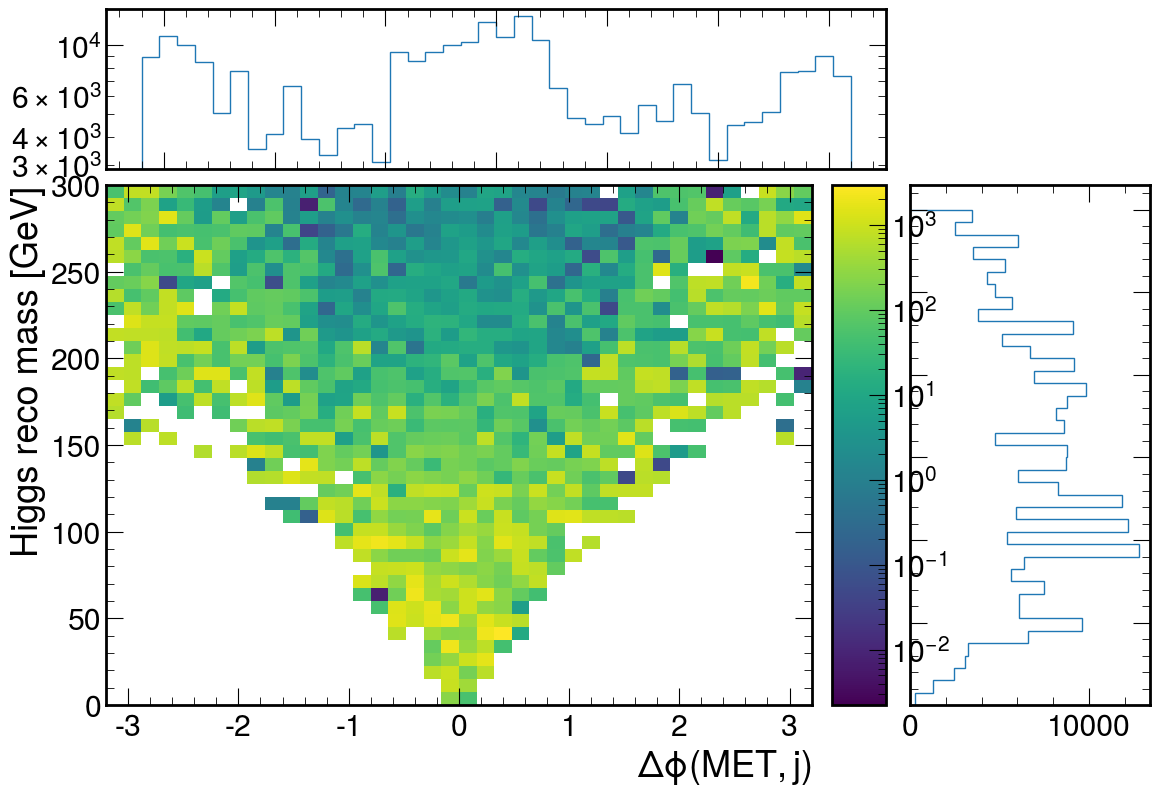

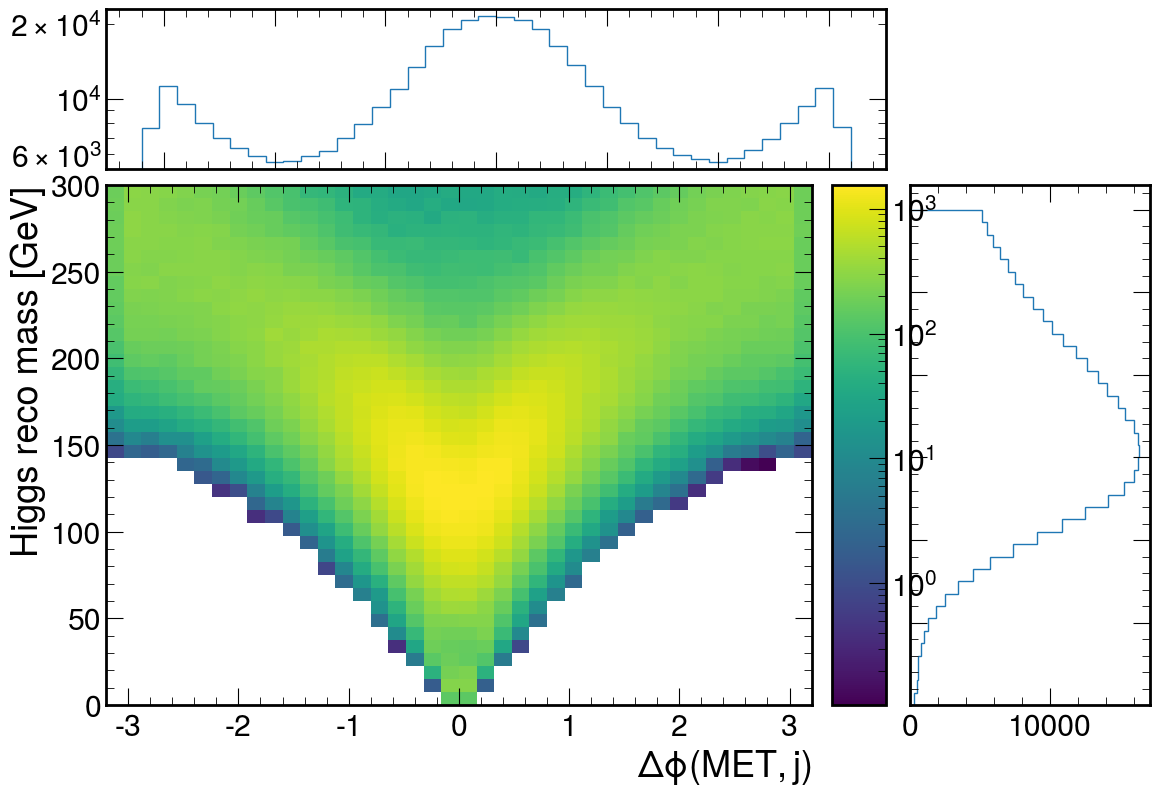

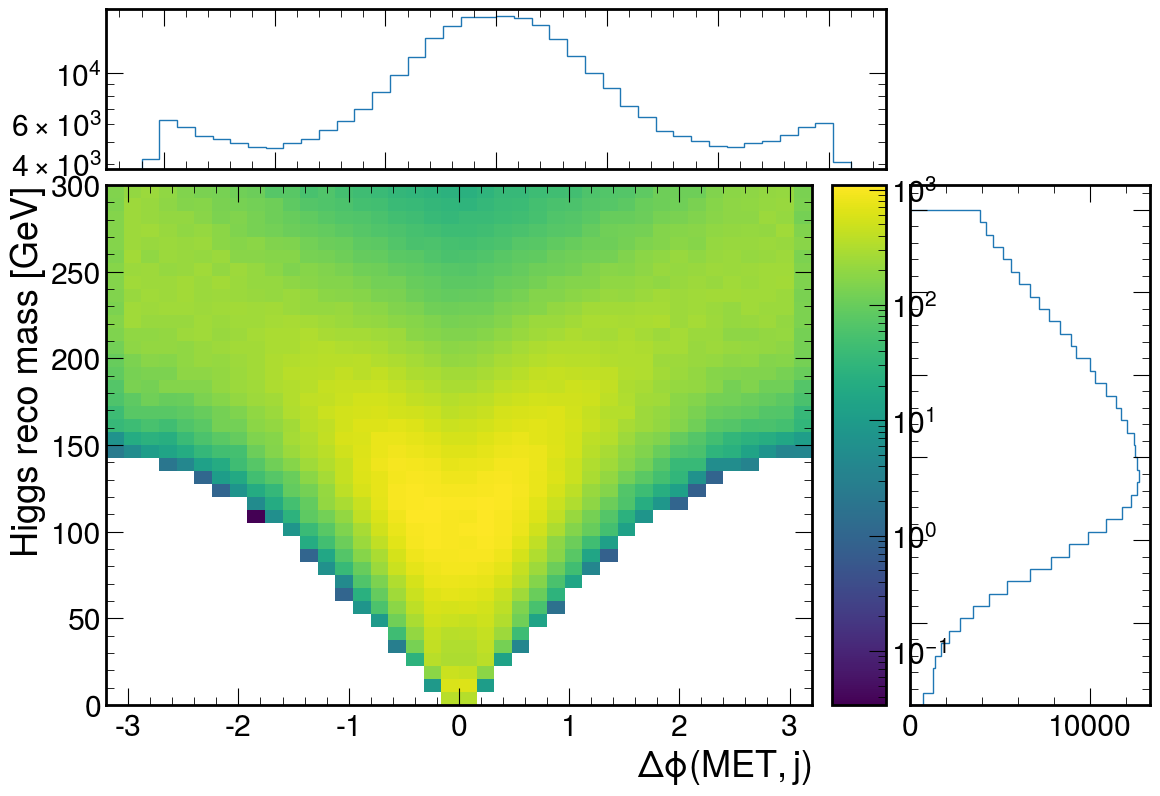

In [102]:
for k in ["ggH", "VBF", "QCD", "TT", "WJets"]:
    fig = plt.figure(figsize=(12,8))
    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    bottom_h = left_h = left + width + 0.02
    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom_h, width, 0.2]
    rect_histy = [left_h, bottom, 0.2, height]

    ax2d = plt.axes(rect_scatter)
    axHistx = plt.axes(rect_histx)
    axHisty = plt.axes(rect_histy)
    mplhep.hist2dplot(
        h_metdphi[{"name": k, "channel": sum}],
        flow="none",
        norm=mpl.colors.LogNorm(),
        ax=ax2d
    )
    mplhep.histplot(
        h_metdphi[{"name": k, "channel": sum, "hm": sum}],
        flow="none",
        ax=axHistx
    )
    mplhep.histplot(
        h_metdphi[{"name": k, "channel": sum, "metdphi": sum}],
        flow="none",
        ax=axHisty,
        orientation='horizontal'
    )
    axHistx.set_xlabel("")
    axHisty.set_xlabel("")
    axHistx.set_yscale("log")
    from matplotlib.ticker import NullFormatter
    nullfmt = NullFormatter() 
    axHistx.xaxis.set_major_formatter(nullfmt)
    axHisty.yaxis.set_major_formatter(nullfmt)
    plt.tight_layout()
    fig.savefig(f"metdphi_hm_{k}.png")

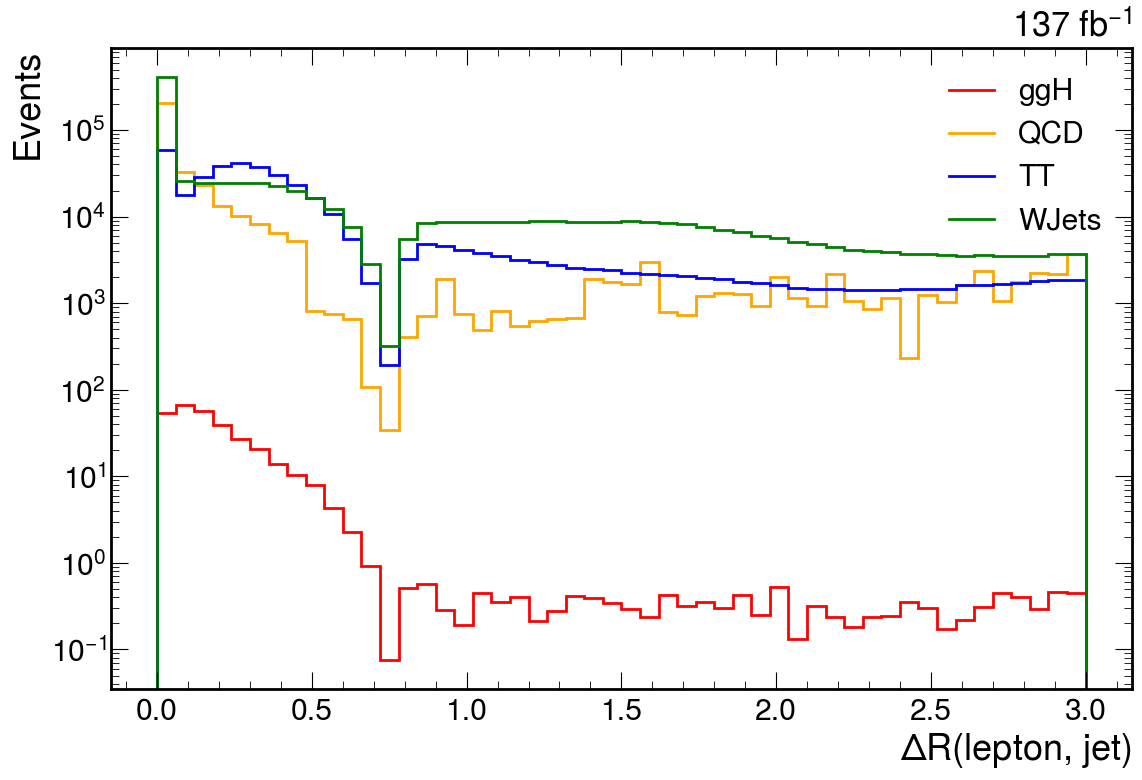

In [16]:
fig, ax = plt.subplots(figsize=(12, 8))
legend_elements = []
color_by_sample = {
    "ggH": "red",
    #"VBF": "pink",
    "QCD": "orange",
    "TT": "blue",
    "WJets": "green",
}
for key in color_by_sample.keys():
    mplhep.histplot(
        h_lepdr[{"leppt":sum, "name": key, "channel": sum}],
        lw=2,
        #density=True,
        color=color_by_sample[key],
        flow="none"
    )
    legend_elements.append(
        Line2D([0], [0], color=color_by_sample[key], lw=2, label=key)
    )
ax.set_yscale("log")
ax.legend(handles=legend_elements)
ax.set_ylabel("Events")
plt.tight_layout()
mplhep.cms.lumitext(r"137 fb$^{-1}$")
fig.savefig("lepdr.png")

/tmp/ipykernel_2996/4153931165.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


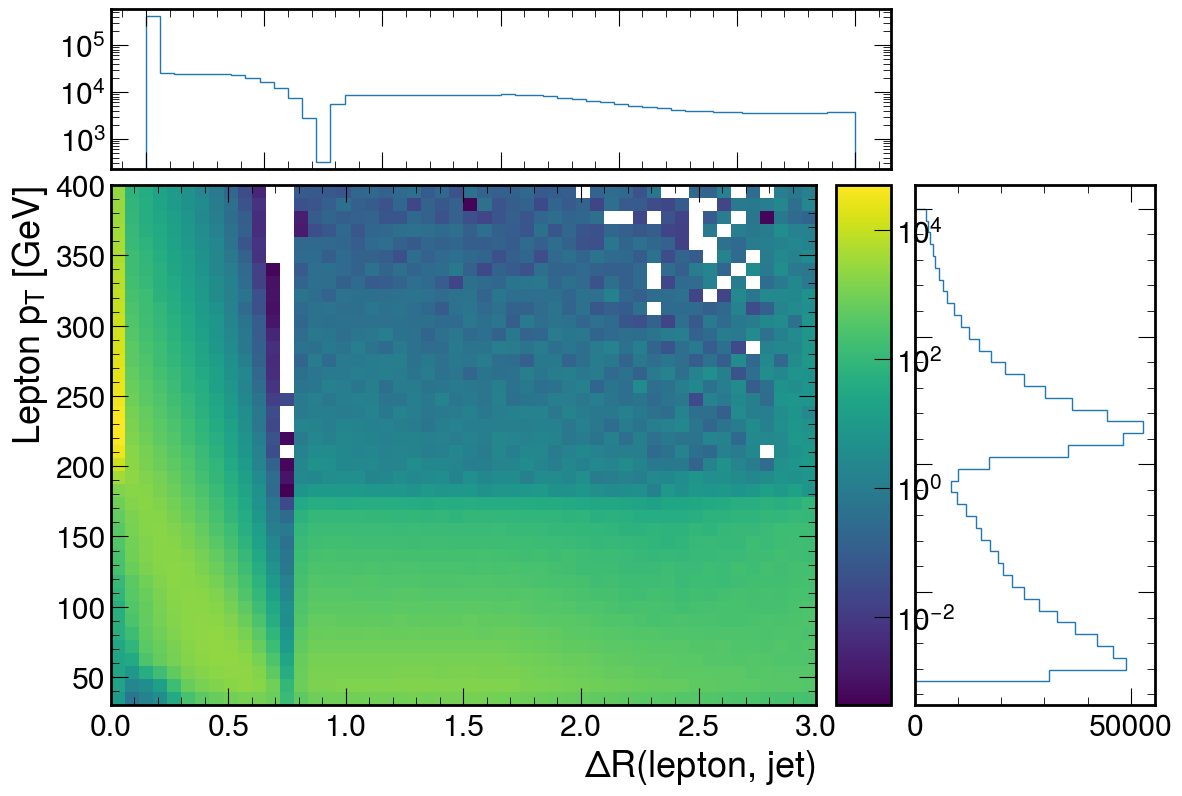

In [44]:
fig = plt.figure(figsize=(12,8))
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
bottom_h = left_h = left + width + 0.02
rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom_h, width, 0.2]
rect_histy = [left_h, bottom, 0.2, height]

ax2d = plt.axes(rect_scatter)
axHistx = plt.axes(rect_histx)
axHisty = plt.axes(rect_histy)
mplhep.hist2dplot(
    h_lepdr[{"name": "WJets", "channel": sum}],
    flow="none",
    norm=mpl.colors.LogNorm(),
    ax=ax2d
)
mplhep.histplot(
    h_lepdr[{"name": "WJets", "channel": sum, "leppt": sum}],
    flow="none",
    ax=axHistx
)
mplhep.histplot(
    h_lepdr[{"name": "WJets", "channel": sum, "lepdr": sum}],
    flow="none",
    ax=axHisty,
    orientation='horizontal'
)
axHistx.set_xlabel("")
axHisty.set_xlabel("")
axHistx.set_yscale("log")
from matplotlib.ticker import NullFormatter
nullfmt = NullFormatter() 
axHistx.xaxis.set_major_formatter(nullfmt)
axHisty.yaxis.set_major_formatter(nullfmt)
plt.tight_layout()
fig.savefig("lepdr_leppt_wjets.png")

In [47]:
hm_axis = hist.axis.Regular(
    40, 0, 300, name="hm", label=r"Higgs reco mass [GeV]"
)
hmpart_axis = hist.axis.Regular(
    40, 0, 300, name="part", label=r"ParT mass [GeV]"
)
wqq_axis = hist.axis.Regular(
    40, 0, 200, name="wqq", label=r"W(qq) fatjet mass [GeV]"
)
wlnu_axis = hist.axis.Regular(
    40, 0, 200, name="wlnu", label=r"W($\ell \nu$) mass [GeV]"
)
mass_axis = hist.axis.Regular(
    40, 0, 300, name="mass", label=r"FatJet mass [GeV]"
)
channel_axis = hist.axis.StrCategory([], name="channel", growth=True)
sample_axis = hist.axis.StrCategory([], name="name", growth=True)

h_hm = hist.Hist(hm_axis, channel_axis, sample_axis)
h_hmpart = hist.Hist(hmpart_axis, channel_axis, sample_axis)
h_wqq = hist.Hist(wqq_axis, channel_axis, sample_axis)
h_wlnu = hist.Hist(wlnu_axis, channel_axis, sample_axis)
h_mass = hist.Hist(mass_axis, channel_axis, sample_axis)
h_comp =  hist.Hist(hm_axis, hmpart_axis, channel_axis, sample_axis)
odir = "/eos/uscms/store/user/cmantill/boostedhiggs/Jan6_2018/"

samples_dict = {
    "ggH": ["GluGluHToWW_Pt-200ToInf_M-125"],
    "VBF": ["VBFHToWWToAny_M-125_TuneCP5_withDipoleRecoil"],
    "TT": [
        "TTTo2L2Nu",
        "TTToHadronic",
        "TTToSemiLeptonic",
    ],
    "WJets": [
        #"WJetsToLNu_HT-100To200",
        "WJetsToLNu_HT-200To400",
        "WJetsToLNu_HT-400To600",
        "WJetsToLNu_HT-600To800",
        "WJetsToLNu_HT-800To1200",
        "WJetsToLNu_HT-1200To2500",
        "WJetsToLNu_HT-2500ToInf",
    ],
}
year = "2018"

pt_threshold = {
    "mu": 55,
    "ele": 120,
}

for ch in ["ele", "mu"]:
    for key,samples in samples_dict.items():
        for sample in samples:
            parquet_files = glob.glob(f"{odir}/{sample}/outfiles/*_{ch}.parquet")
            pkl_files = glob.glob(f"{odir}/{sample}/outfiles/*.pkl")

            data = pd.read_parquet(parquet_files, columns=[
                                                           f"weight_{ch}", 
                                                           "rec_higgs_m",
                                                           "met_pt",
                                                           "fj_mass",
                                                           "fj_ParT_mass",
                                                           "rec_W_qq_m",
                                                           "rec_W_lnu_m",
                                                           ])

            luminosity = 137640.0

            event_weight = get_xsecweight(pkl_files, year, sample, False, luminosity)
            event_weight *= data[f"weight_{ch}"]

            rec_higgs_m = data["rec_higgs_m"].values
            part_mass = data["fj_ParT_mass"].values
            wqq_mass = data["rec_W_qq_m"].values
            wlnu_mass = data["rec_W_lnu_m"].values
            mass = data["fj_mass"].values
        
            h_hm.fill(hm=rec_higgs_m, channel=ch, name=key, weight=event_weight)
            h_hmpart.fill(part=part_mass, channel=ch, name=key, weight=event_weight)
            h_wqq.fill(wqq_mass, ch, key, weight=event_weight)
            h_wlnu.fill(wlnu_mass, ch, key, weight=event_weight)
            h_mass.fill(mass, ch, key, weight=event_weight)
            h_comp.fill(rec_higgs_m, part_mass, ch, key, weight=event_weight)

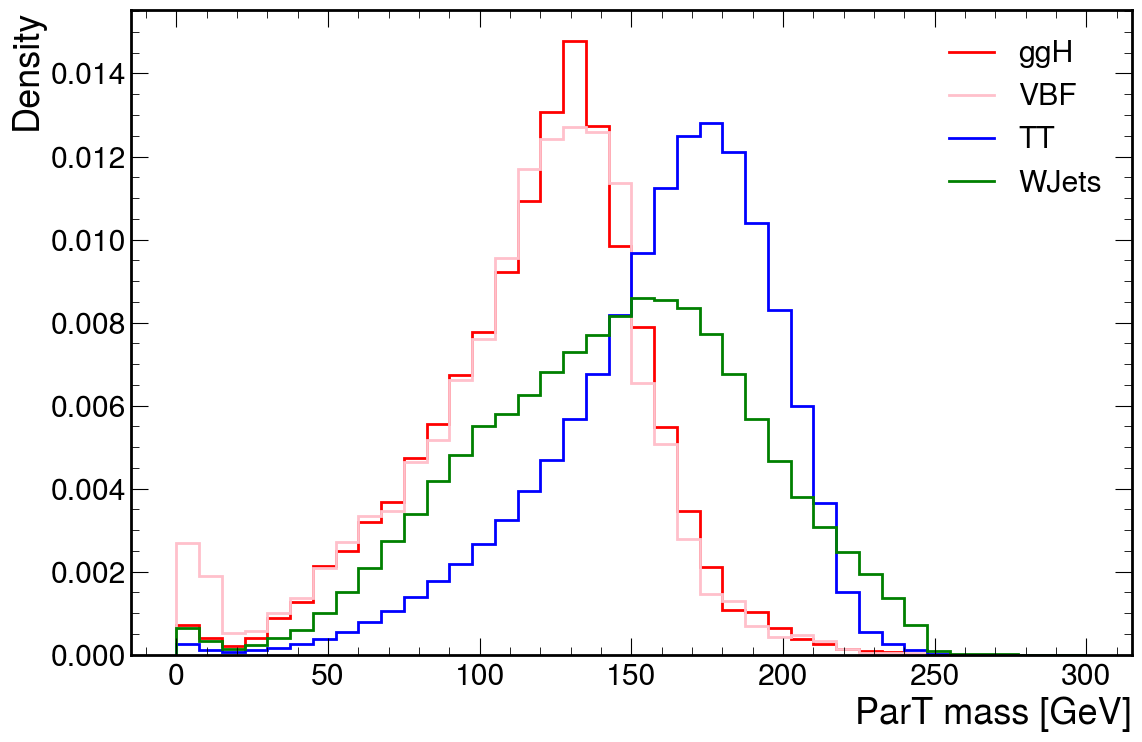

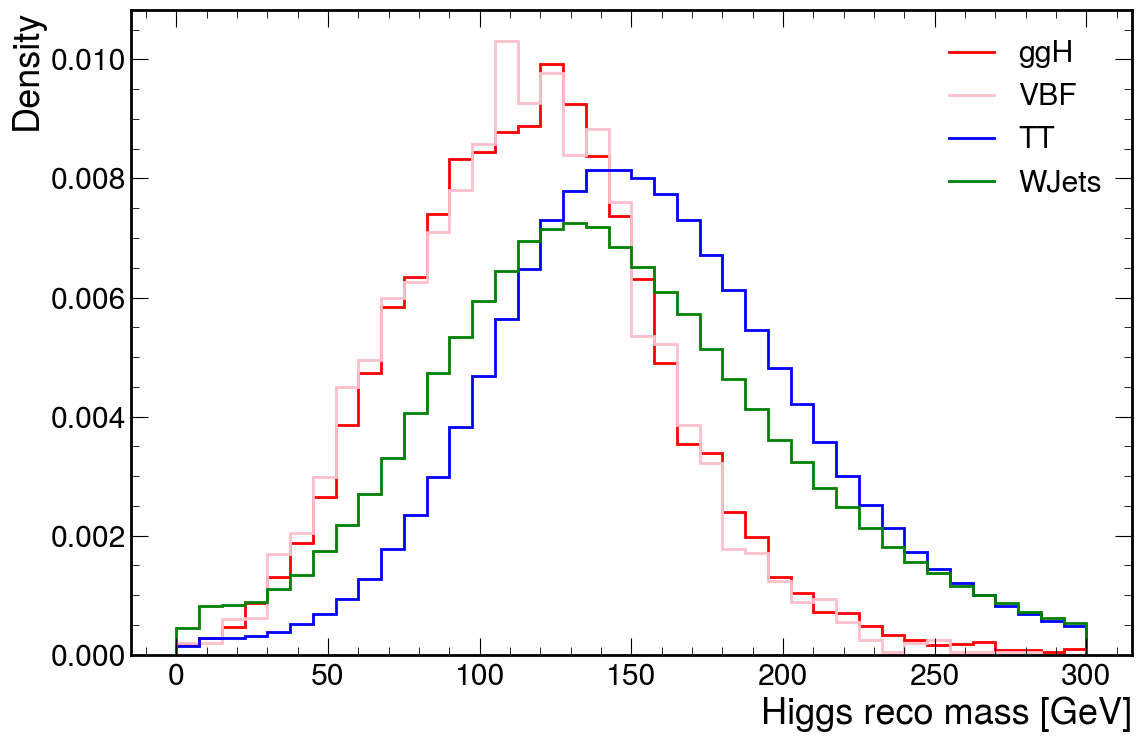

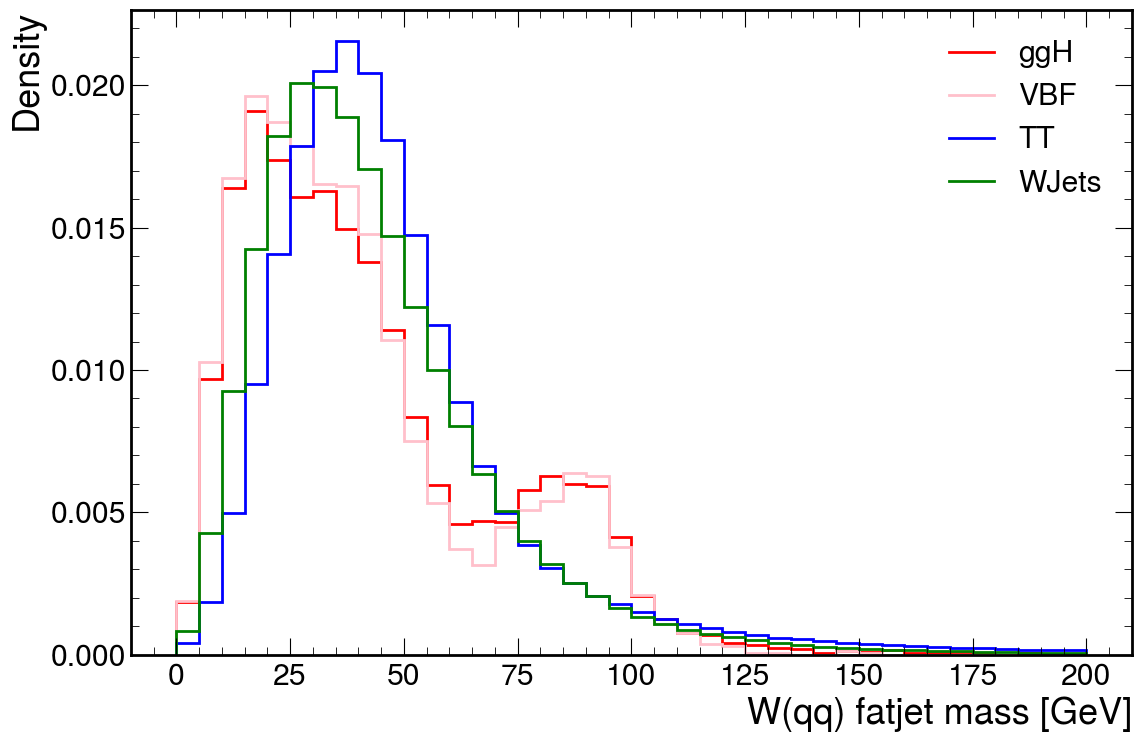

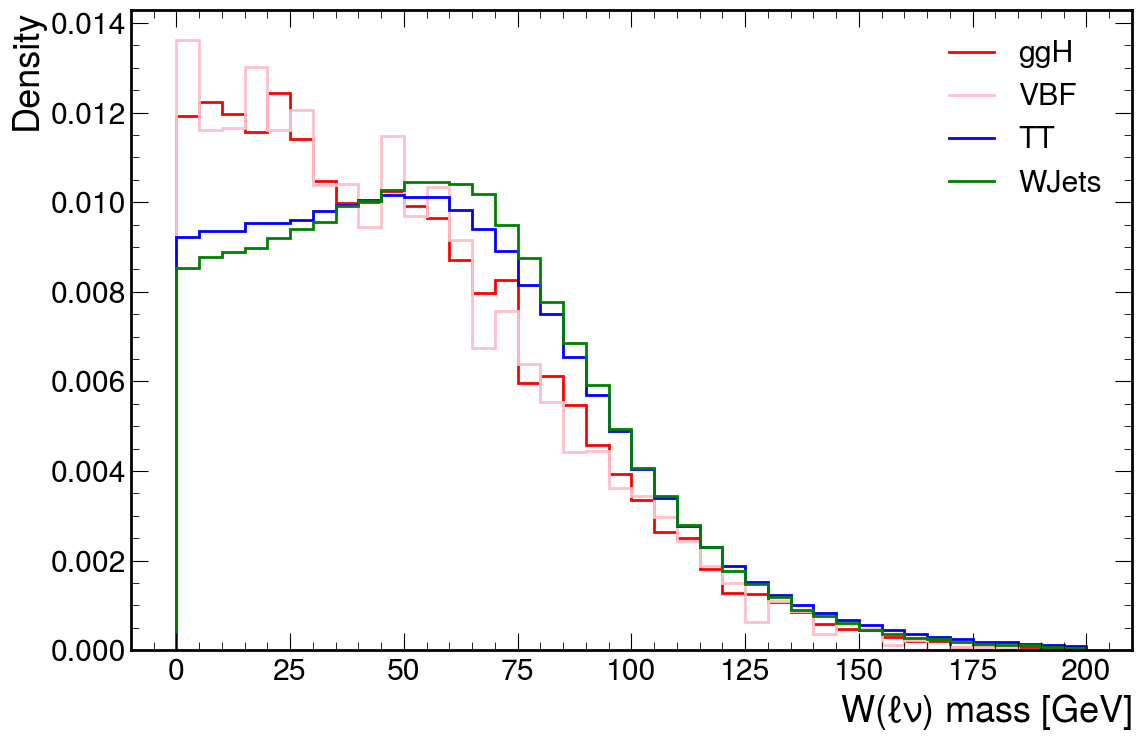

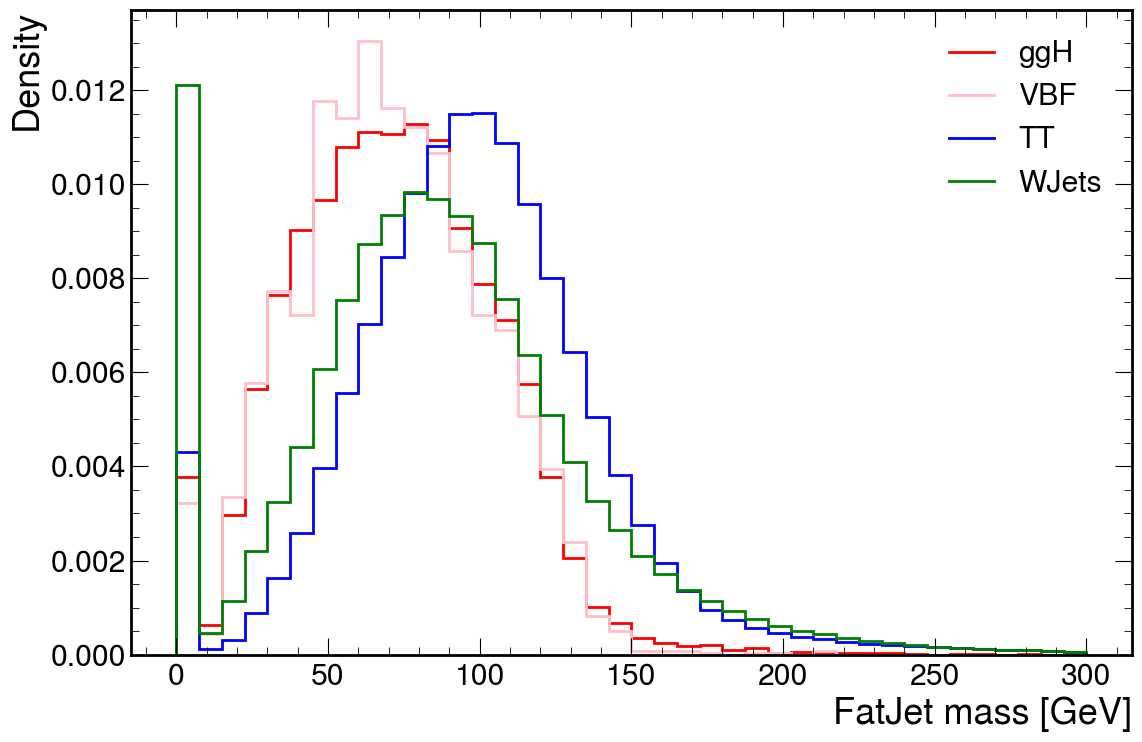

In [15]:
to_plot = {
    "hmpart": h_hmpart,
    "hm": h_hm,
    "mwqq": h_wqq,
    "mwlnu": h_wlnu,
    "mass": h_mass,
}

color_by_sample = {
    "ggH": "red",
    "VBF": "pink",
    "TT": "blue",
    "WJets": "green",
}

for hkey, h in to_plot.items():
    fig, ax = plt.subplots(figsize=(12, 8))
    legend_elements = []
    for key in color_by_sample.keys():
        mplhep.histplot(
            h[{"name": key, "channel": sum}],
            lw=2,
            density=True,
            color=color_by_sample[key],
            flow="none"
        )
        legend_elements.append(
            Line2D([0], [0], color=color_by_sample[key], lw=2, label=key)
        )
    ax.legend(handles=legend_elements)
    ax.set_ylabel("Density")
    plt.tight_layout()
    fig.savefig(f"{hkey}_presel.png")

Using msoftdrop for the FatJet mass

In [44]:
hm_axis = hist.axis.Regular(
    40, 0, 300, name="hm", label=r"Higgs reco mass [GeV]"
)
msd_axis = hist.axis.Regular(
    40, 0, 300, name="msd", label=r"FatJet softdrop mass [GeV]"
)
hmpart_axis = hist.axis.Regular(
    40, 0, 300, name="part", label=r"ParT mass [GeV]"
)
wqq_axis = hist.axis.Regular(
    40, 0, 200, name="wqq", label=r"W(qq) fatjet mass [GeV]"
)
wlnu_axis = hist.axis.Regular(
    40, 0, 200, name="wlnu", label=r"W($\ell \nu$) mass [GeV]"
)
channel_axis = hist.axis.StrCategory([], name="channel", growth=True)
sample_axis = hist.axis.StrCategory([], name="name", growth=True)

h_jsoftdrop_msd = hist.Hist(msd_axis, channel_axis, sample_axis)
h_hm_msd = hist.Hist(hm_axis, channel_axis, sample_axis)
h_wqq_msd = hist.Hist(wqq_axis, hm_axis, channel_axis, sample_axis)
h_wlnu_msd = hist.Hist(wlnu_axis, hm_axis, channel_axis, sample_axis)

odir = "/eos/uscms/store/user/cmantill/boostedhiggs/Jan16_allsel_2018/"

samples_dict = {
    "ggH": ["GluGluHToWW_Pt-200ToInf_M-125"],
    "VBF": ["VBFHToWWToAny_M-125_TuneCP5_withDipoleRecoil"],
    "TT": [
        "TTTo2L2Nu",
        "TTToHadronic",
        "TTToSemiLeptonic",
    ],
    "WJets": [
        #"WJetsToLNu_HT-100To200",
        "WJetsToLNu_HT-200To400",
        "WJetsToLNu_HT-400To600",
        "WJetsToLNu_HT-600To800",
        "WJetsToLNu_HT-800To1200",
        "WJetsToLNu_HT-1200To2500",
        "WJetsToLNu_HT-2500ToInf",
    ],
}
year = "2018"

pt_threshold = {
    "mu": 55,
    "ele": 120,
}

for ch in ["ele", "mu"]:
    for key,samples in samples_dict.items():
        for sample in samples:
            parquet_files = glob.glob(f"{odir}/{sample}/outfiles/*_{ch}.parquet")
            pkl_files = glob.glob(f"{odir}/{sample}/outfiles/*.pkl")

            data = pd.read_parquet(parquet_files, columns=[
                                                           f"weight_{ch}", 
                                                           "rec_higgs_m",
                                                           "met_pt",
                                                           "fj_mass",
                                                           #"fj_ParT_mass",
                                                           "rec_W_qq_m",
                                                           "rec_W_lnu_m",
                                                           ])

            luminosity = 137640.0

            event_weight = get_xsecweight(pkl_files, year, sample, False, luminosity)
            event_weight *= data[f"weight_{ch}"]
            rec_higgs_m = data["rec_higgs_m"].values
            wqq_mass = data["rec_W_qq_m"].values
            wlnu_mass = data["rec_W_lnu_m"].values
            msd_mass = data["fj_mass"].values

            pre_sel = (msd_mass > 5)

            h_hm_msd.fill(hm=rec_higgs_m[pre_sel], channel=ch, name=key, weight=event_weight[pre_sel])
            h_wqq_msd.fill(wqq_mass[pre_sel], rec_higgs_m[pre_sel], ch, key, weight=event_weight[pre_sel])
            h_wlnu_msd.fill(wlnu_mass[pre_sel], rec_higgs_m[pre_sel], ch, key, weight=event_weight[pre_sel])
            h_jsoftdrop_msd.fill(msd_mass[pre_sel], ch, key, weight=event_weight[pre_sel])

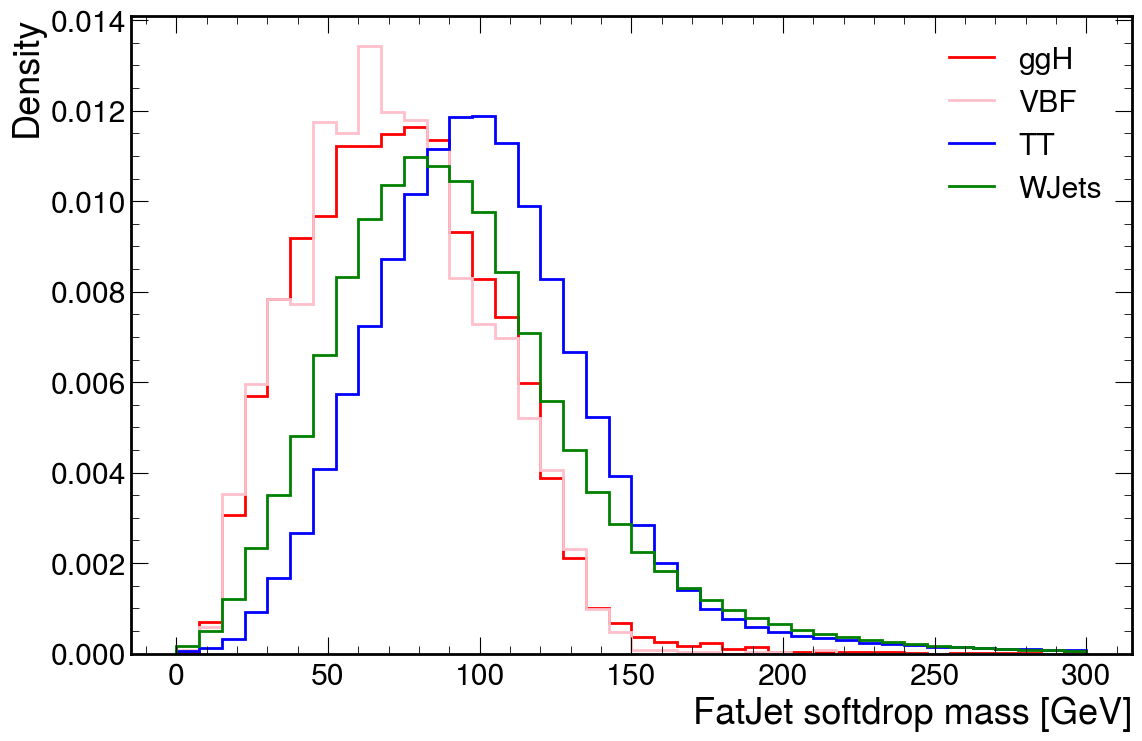

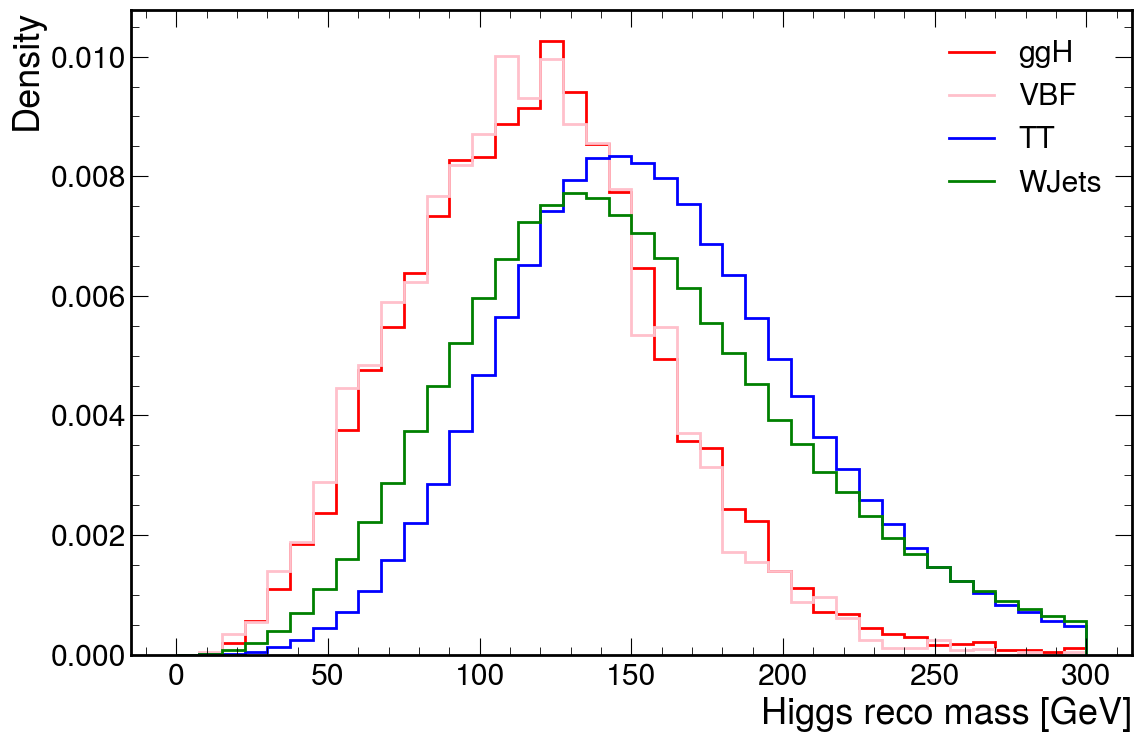

In [37]:
to_plot = {
    "hmsd": h_jsoftdrop_msd,
    "hm": h_hm_msd,
   #"mwqq": h_wqq_msd,
   # "mwlnu": h_wlnu_msd,
}

color_by_sample = {
    "ggH": "red",
    "VBF": "pink",
    #"QCD": "orange",
    "TT": "blue",
    "WJets": "green",
}

for hkey, h in to_plot.items():
    fig, ax = plt.subplots(figsize=(12, 8))
    legend_elements = []
    for key in color_by_sample.keys():
        mplhep.histplot(
            h[{"name": key, "channel": sum}],
            lw=2,
            density=True,
            color=color_by_sample[key],
            flow="none"
        )
        legend_elements.append(
            Line2D([0], [0], color=color_by_sample[key], lw=2, label=key)
        )
    ax.legend(handles=legend_elements)
    ax.set_ylabel("Density")
    plt.tight_layout()
    fig.savefig(f"{hkey}_presel_msd.png")

/tmp/ipykernel_1692/1855332124.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


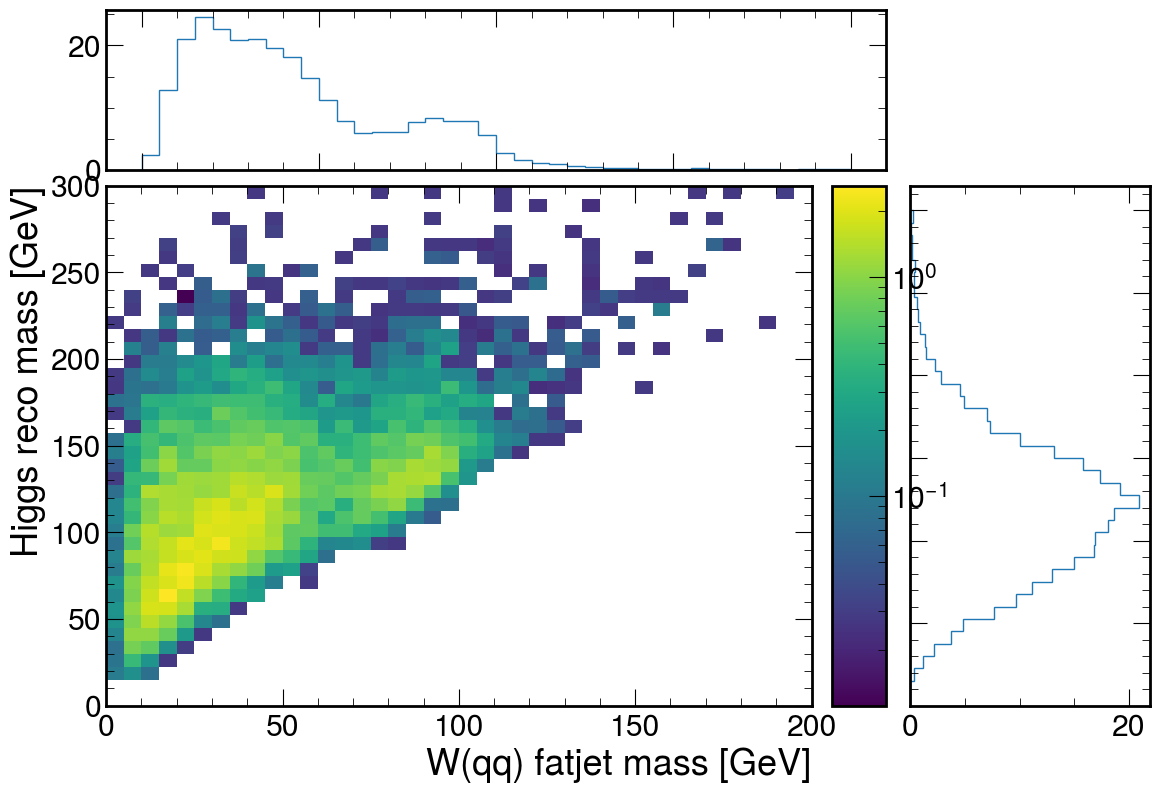

In [46]:
fig = plt.figure(figsize=(12,8))
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
bottom_h = left_h = left + width + 0.02
rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom_h, width, 0.2]
rect_histy = [left_h, bottom, 0.2, height]

ax2d = plt.axes(rect_scatter)
axHistx = plt.axes(rect_histx)
axHisty = plt.axes(rect_histy)
mplhep.hist2dplot(
    h_wqq_msd[{"name": "ggH", "channel": sum}],
    flow="none",
    norm=mpl.colors.LogNorm(),
    ax=ax2d
)
mplhep.histplot(
    h_wqq_msd[{"name": "ggH", "channel": sum, "hm": sum}],
    flow="none",
    ax=axHistx
)
mplhep.histplot(
    h_wqq_msd[{"name": "ggH", "channel": sum, "wqq": sum}],
    flow="none",
    ax=axHisty,
    orientation='horizontal'
)
axHistx.set_xlabel("")
axHisty.set_xlabel("")
#axHistx.set_yscale("log")
from matplotlib.ticker import NullFormatter
nullfmt = NullFormatter() 
axHistx.xaxis.set_major_formatter(nullfmt)
axHisty.yaxis.set_major_formatter(nullfmt)
plt.tight_layout()
fig.savefig(f"2d_wqq_ggH_hm.png")